# CMS Open Data Tutorial

## First COMETA workshop on artificial intelligence for multi-boson physics
## NIKHEF 2-3 Oct 2024

## CMS Open Data

Before we do anything let's go to the [CERN Open Data Portal](https://opendata.cern.ch/) and discover what open data and resources are available.

## Accessing data

The [cernopendata-client](https://cernopendata-client.readthedocs.io/en/latest/) is a useful command line tool for accessing data in the CERN Open Data Portal. 


In a terminal in your virtual environment you can install it with the following command:
```
pip install cernopendata-client
```

We'll use it here in the notebook using the command line prompt `!`

Let's run the command with the help option:

In [76]:
!cernopendata-client --help

Usage: cernopendata-client [OPTIONS] COMMAND [ARGS]...

  Command-line client for interacting with CERN Open Data portal.

Options:
  --help  Show this message and exit.

Commands:
  download-files      Download data files belonging to a record.
  get-file-locations  Get a list of data file locations of a record.
  get-metadata        Get metadata content of a record.
  list-directory      List contents of a EOSPUBLIC Open Data directory.
  verify-files        Verify downloaded data file integrity.
  version             Return cernopendata-client version.


Recall that each CMS dataset is associated to a record on the CODP. Let's select a QCD NANOAODSIM dataset:

[Simulated dataset QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8 in NANOAODSIM format for 2016 collision data](https://opendata.cern.ch/record/63168)

which is record number 63168.

With the CLI we can list the metadata for this dataset:

In [77]:
!cernopendata-client get-metadata --recid 63168

{
    "$schema": "http://opendata.cern.ch/schema/records/record-v1.0.0.json",
    "_bucket": "5d4b6d5f-a82c-4654-980d-7d8d7978b1b2",
    "abstract": {
        "description": "<p>Simulated dataset QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8 in NANOAODSIM format for 2016 collision data.</p><p>See the description of the simulated dataset names in: <a href=\"/about/CMS-Simulated-Dataset-Names\">About CMS simulated dataset names</a>.</p><p>These simulated datasets correspond to the collision data collected by the CMS experiment in 2016.</p>"
    },
    "accelerator": "CERN-LHC",
    "categories": {
        "primary": "Standard Model Physics",
        "secondary": [
            "QCD"
        ],
        "source": "CMS Collaboration"
    },
    "collaboration": {
        "name": "CMS Collaboration"
    },
    "collections": [
        "CMS-Simulated-Datasets"
    ],
    "collision_information": {
        "energy": "13TeV",
        "type": "pp"
    },
    "control_number": "63168",
    "datas

Let's list the files available in this record:

In [78]:
!cernopendata-client get-file-locations --recid 63168 --verbose

http://opendata.cern.ch/eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/130000/1C569D85-60AE-7D43-B42B-6D6FD1D66CC7.root	2761359192	adler32:1b3c3628
http://opendata.cern.ch/eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/130000/2EDCC683-1B4B-614B-BEB7-D80BBC20AD8E.root	804633059	adler32:5ff6eb2b
http://opendata.cern.ch/eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/270000/19E8D842-3175-1449-AF6C-FD9C69D12724.root	54891248	adler32:434582cb
http://opendata.cern.ch/eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/270000/3957434B-7E09-3B4C-8329-FD44D82C7DB7.root	148144417	adler32:978c9539
http://opendata.cern.ch/eos/opendata/cms/mc/RunIISummer20UL1

By default the files are given with the HTTP protocol. If you wish to use XRootD: 

In [79]:
!cernopendata-client get-file-locations --recid 63168 --protocol xrootd

root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/130000/1C569D85-60AE-7D43-B42B-6D6FD1D66CC7.root
root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/130000/2EDCC683-1B4B-614B-BEB7-D80BBC20AD8E.root
root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/270000/19E8D842-3175-1449-AF6C-FD9C69D12724.root
root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/270000/3957434B-7E09-3B4C-8329-FD44D82C7DB7.root
root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1

Now let's download a file, one of the smaller ones. Note that the `cernopendata-client` has a download files option but since we know which file we want well use `curl` instead.

In [80]:
!cernopendata-client download-files --help

Usage: cernopendata-client download-files [OPTIONS]

  Download data files belonging to a record.

  Select a CERN Open Data bibliographic record by a record ID, a DOI, or a
  title and download data files belonging to this record.

  Examples:

       $ cernopendata-client download-files --recid 5500

       $ cernopendata-client download-files --recid 5500 --filter-name
       BuildFile.xml

       $ cernopendata-client download-files --recid 5500 --filter-regexp py$

       $ cernopendata-client download-files --recid 5500 --filter-range 1-4

       $ cernopendata-client download-files --recid 5500 --filter-range
       1-2,5-7

       $ cernopendata-client download-files --recid 5500 --filter-regexp py
       --filter-range 1-2

Options:
  --recid INTEGER                 Record ID
  --doi TEXT                      Digital Object Identifier
  --title TEXT                    Record title
  --protocol [http|xrootd]        Protocol to be used in links [http,xrootd]
  --expand / --no-ex

In [81]:
!curl -O http://opendata.cern.ch/eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/270000/397D1673-167A-CF46-9E79-D7069D9AC359.root

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6262k  100 6262k    0     0  4526k      0  0:00:01  0:00:01 --:--:-- 4525k


## Exploring the data

In [82]:
import numpy as np
import matplotlib.pylab as plt

import uproot
import awkward as ak

In [83]:
infile_name = '397D1673-167A-CF46-9E79-D7069D9AC359.root'
infile = uproot.open(infile_name)

keys = infile.keys()
print(keys)

['tag;1', 'Events;1', 'LuminosityBlocks;1', 'Runs;1', 'MetaData;1', 'ParameterSets;1']


In [84]:
events = infile['Events']
print(events.keys())

['run', 'luminosityBlock', 'event', 'HTXS_Higgs_pt', 'HTXS_Higgs_y', 'HTXS_stage1_1_cat_pTjet25GeV', 'HTXS_stage1_1_cat_pTjet30GeV', 'HTXS_stage1_1_fine_cat_pTjet25GeV', 'HTXS_stage1_1_fine_cat_pTjet30GeV', 'HTXS_stage1_2_cat_pTjet25GeV', 'HTXS_stage1_2_cat_pTjet30GeV', 'HTXS_stage1_2_fine_cat_pTjet25GeV', 'HTXS_stage1_2_fine_cat_pTjet30GeV', 'HTXS_stage_0', 'HTXS_stage_1_pTjet25', 'HTXS_stage_1_pTjet30', 'HTXS_njets25', 'HTXS_njets30', 'nboostedTau', 'boostedTau_chargedIso', 'boostedTau_eta', 'boostedTau_leadTkDeltaEta', 'boostedTau_leadTkDeltaPhi', 'boostedTau_leadTkPtOverTauPt', 'boostedTau_mass', 'boostedTau_neutralIso', 'boostedTau_phi', 'boostedTau_photonsOutsideSignalCone', 'boostedTau_pt', 'boostedTau_puCorr', 'boostedTau_rawAntiEle2018', 'boostedTau_rawIso', 'boostedTau_rawIsodR03', 'boostedTau_rawMVAnewDM2017v2', 'boostedTau_rawMVAoldDM2017v2', 'boostedTau_rawMVAoldDMdR032017v2', 'boostedTau_charge', 'boostedTau_decayMode', 'boostedTau_jetIdx', 'boostedTau_rawAntiEleCat2018',

What does all this mean? Recall that thankfully in the [dataset record](https://opendata.cern.ch/record/63168) there is a list of file variables (with explanations) under `Dataset semantics`. The link is [here](https://opendata.cern.ch/eos/opendata/cms/dataset-semantics/NanoAODSIM/63168/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8_doc.html).

Let's extract and plot some variables:

* jet multiplicity

* jet pt

* jet eta

In [85]:
jet_mult = events['Jet_nConstituents'].array()
jet_pt = events['Jet_pt'].array()
jet_eta = events['Jet_eta'].array()

In [86]:
print(
    jet_mult
)

[[14, 5], [19, 15], ..., [86, 56, ..., 18], [46, 45, 40, 42, 20, 22, 9, 16, 17]]


Text(0.5, 0, 'jet_eta')

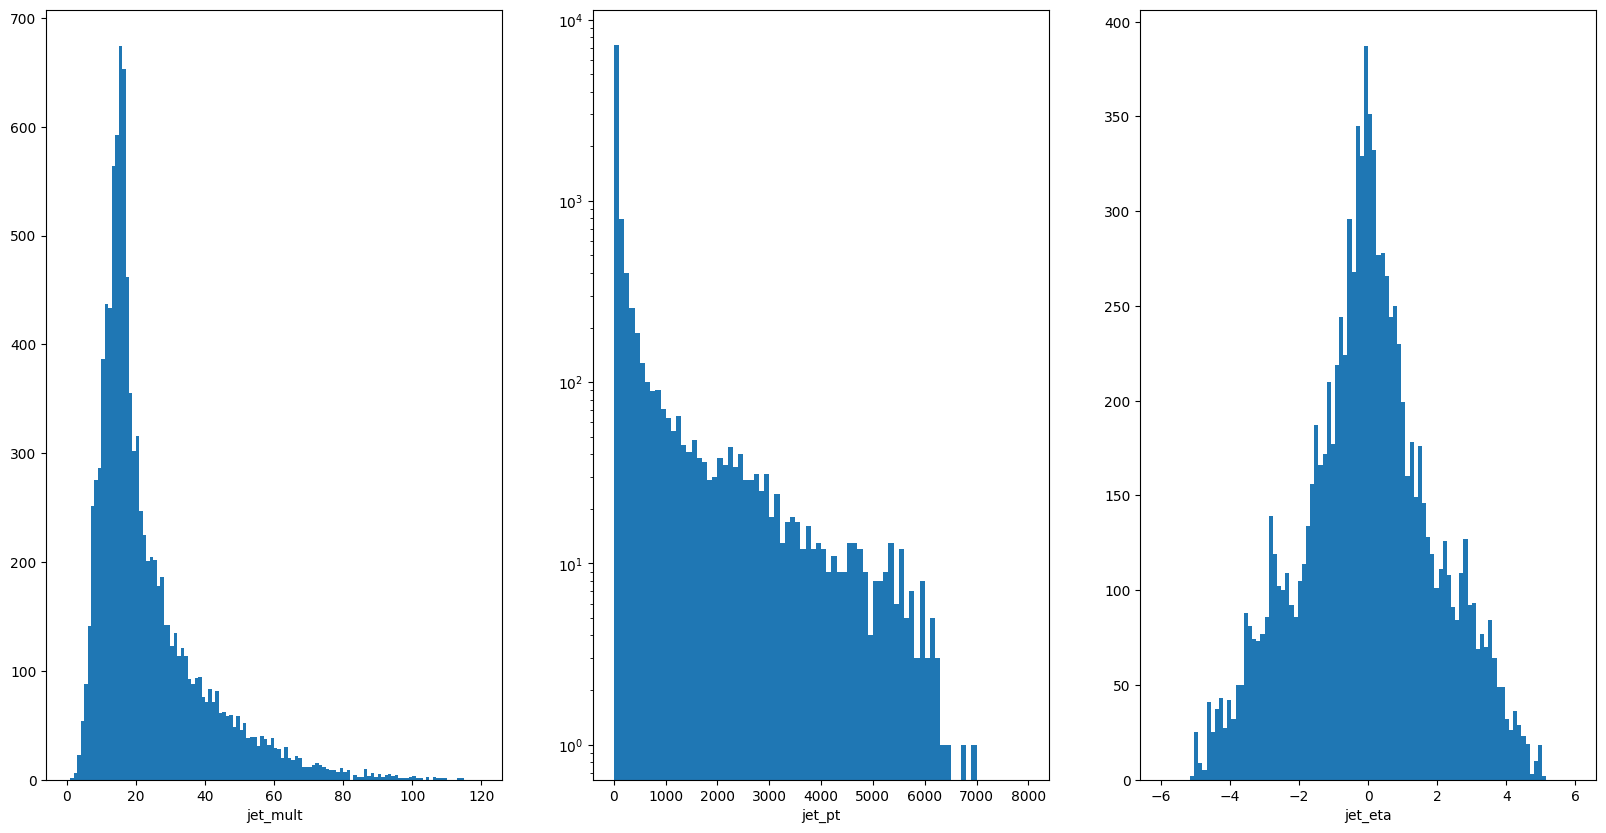

In [87]:
fig, axes = plt.subplots(1, 3, figsize=(20,10))

axes[0].hist(ak.flatten(jet_mult), bins=120, range=(0,120))
axes[0].set_xlabel('jet_mult')

axes[1].hist(ak.flatten(jet_pt), bins=80, range=(0,8000))
axes[1].set_xlabel('jet_pt')
axes[1].set_yscale('log')

axes[2].hist(ak.flatten(jet_eta), bins=100, range=(-6,6))
axes[2].set_xlabel('jet_eta')

In [88]:
jet_partonFlavour = events['Jet_partonFlavour'].array()
 
jet_isPhysG = ak.where(jet_partonFlavour == 21, True, False)

uds_condition = (np.abs(jet_partonFlavour) == 1) | (np.abs(jet_partonFlavour) == 2) | (np.abs(jet_partonFlavour) == 3)

jet_isPhysUDS = ak.where(uds_condition, True, False)

In [89]:
jet_qgl = events['Jet_qgl'].array()

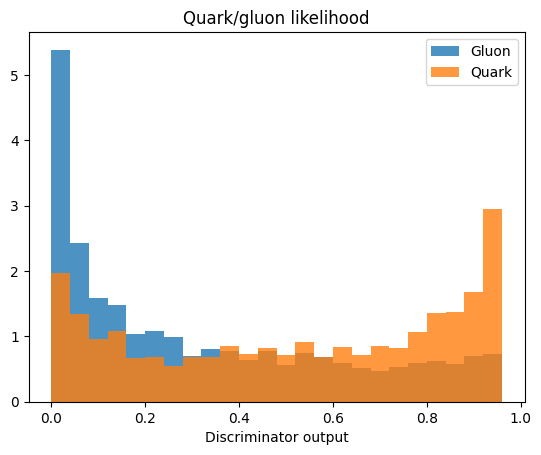

In [90]:
plt.clf()
binning = np.arange(0.0, 1.0, 0.04)

plt.hist(ak.flatten(jet_qgl[jet_isPhysG]), bins=binning, alpha=0.8, label='Gluon', density=1 )
plt.hist(ak.flatten(jet_qgl[jet_isPhysUDS]), bins=binning, alpha=0.8, label='Quark', density=1 )

plt.legend()

plt.xlabel('Discriminator output')
plt.title('Quark/gluon likelihood');